# Kernel Density Mapping

Runs in the generic Anaconda environment (not in ArcGIS).

## 1. Load packages

In [14]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.colors as mcolors
from rasterio.warp import calculate_default_transform, reproject, Resampling
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap
import contextily as cx
import warnings
warnings.filterwarnings('ignore')

## 2. Set parameters

In [3]:
colors = ['blue', 'white', 'red']
n_bins = 100
cmap_name = 'blue_white_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


gis_path = r'E:/Projects/SEACAR_WQ_2024/GIS_Data/'

area_shortnames = {
    'Guana Tolomato Matanzas': 'GTM',
    'Estero Bay': 'EB',
    'Charlotte Harbor': 'CH',
    'Biscayne Bay': 'BB',
    'Big Bend Seagrasses':'BBS'
}

param_shortnames = {
    'Salinity': 'Sal_ppt',
    'Total Nitrogen': 'TN_mgl',
    'Dissolved Oxygen': 'DO_mgl',
    'Turbidity':'Turb_ntu',
    'Secchi Depth':'Secc_m',
    'Water Temperature':'T_c'
}
wb_list = ['BB', 'CH', 'EB', 'GTM']
para_list = ['DO_mgl', 'Sal_ppt', 'Turb_ntu', 'T_c']

## 3. Load continuous sites

In [6]:
dfCon = pd.read_csv(gis_path + 'OEAT_Continuous_WQ-2024-Feb-21.csv', low_memory=False)
dfCon_group = dfCon.groupby(["WaterBody","ParameterName","Latitude_DD","Longitude_DD"])["ResultValue"].mean().reset_index()
gdfCon_group = gpd.GeoDataFrame(dfCon_group,geometry=gpd.points_from_xy(dfCon_group["Longitude_DD"],dfCon_group["Latitude_DD"],crs="EPSG:4326")).to_crs("EPSG:3086")
gdfCon_group["Area_Ab"] = gdfCon_group['WaterBody'].map(area_shortnames)
gdfCon_group["Para_Ab"] = gdfCon_group['ParameterName'].map(param_shortnames)
for wb in wb_list:
    for para in para_list:
        df_used = gdfCon_group[(gdfCon_group["Area_Ab"]==str(wb))&(gdfCon_group["Para_Ab"]==str(para))]
        name = gis_path+r'kde_maps/con_sites/'+str(wb)+"_"+str(para)+"_con.shp"
        df_used.to_file(name)

## 3. Define function to reproject raster

In [7]:
def reproject_raster(src, dst_crs):
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rasterio.MemoryFile() as memfile:
        with memfile.open(**kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest
                )
        return memfile.open()

### Find min and max values of rasters

In [9]:
min_max_ls = []
for wb in wb_list:
    for i, para in enumerate(para_list):
        name = str(wb) + "_" + str(para) + "_kd.tif"
        max_ls = []
        min_ls = []
        with rasterio.open(gis_path + "kde_maps/week/" + name) as src:
            
            # Read the raster data as a numpy array
            raster_data = src.read(1)  # Read the first band
            
            # Calculate max, and min values
            max_ls.append(np.max(raster_data))
            min_ls.append(np.min(raster_data))
        
    min_max_ls.append([min(min_ls),max(max_ls)])

### 4. Generate KDE maps for weekly data

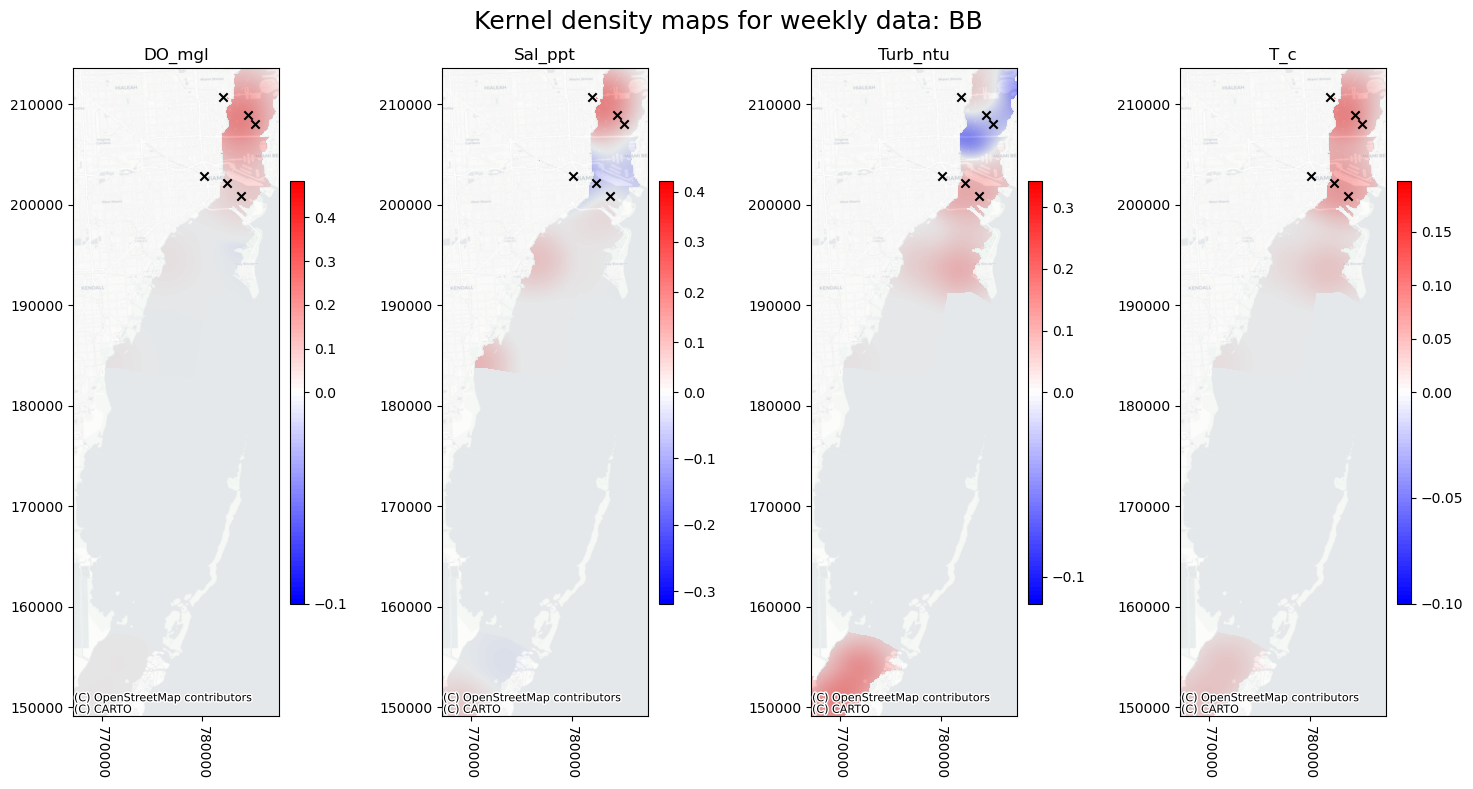

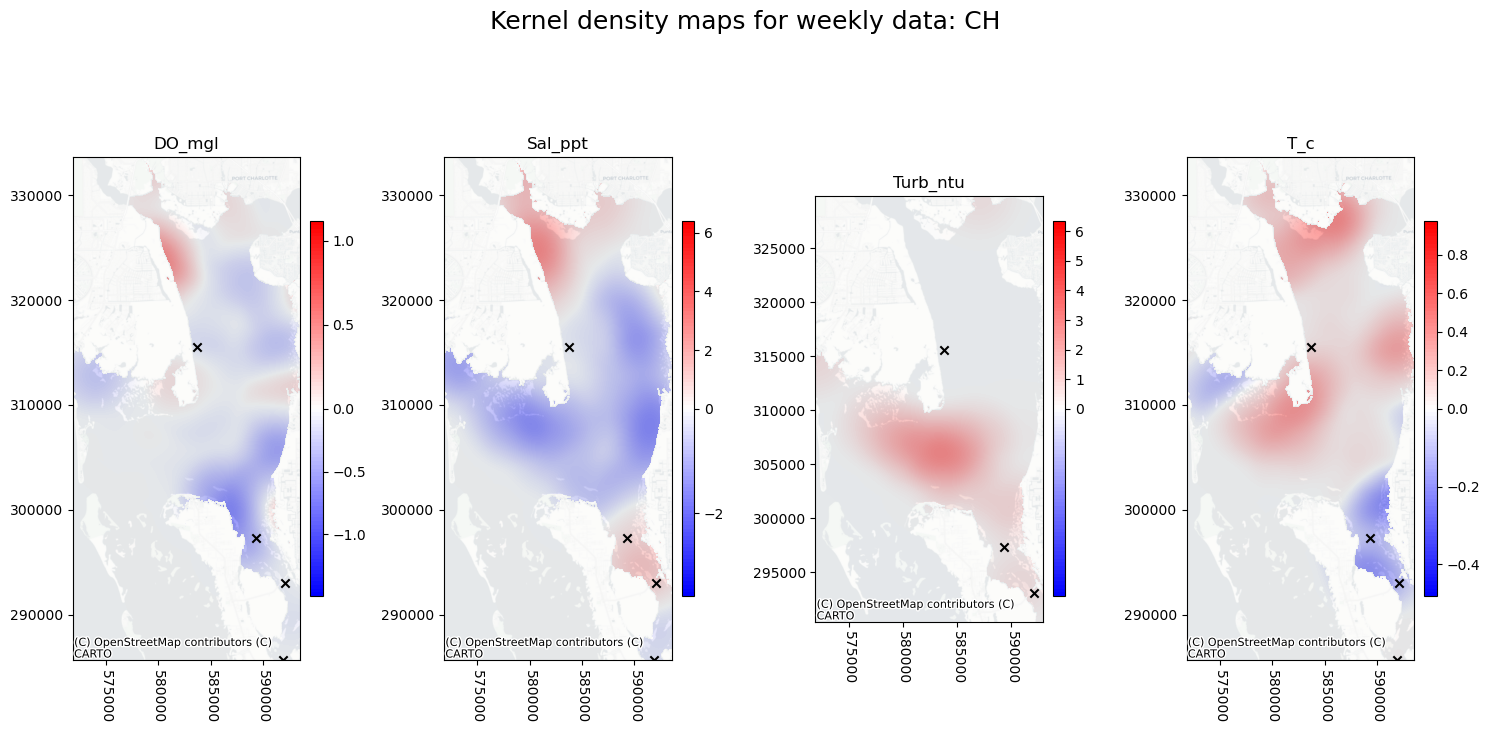

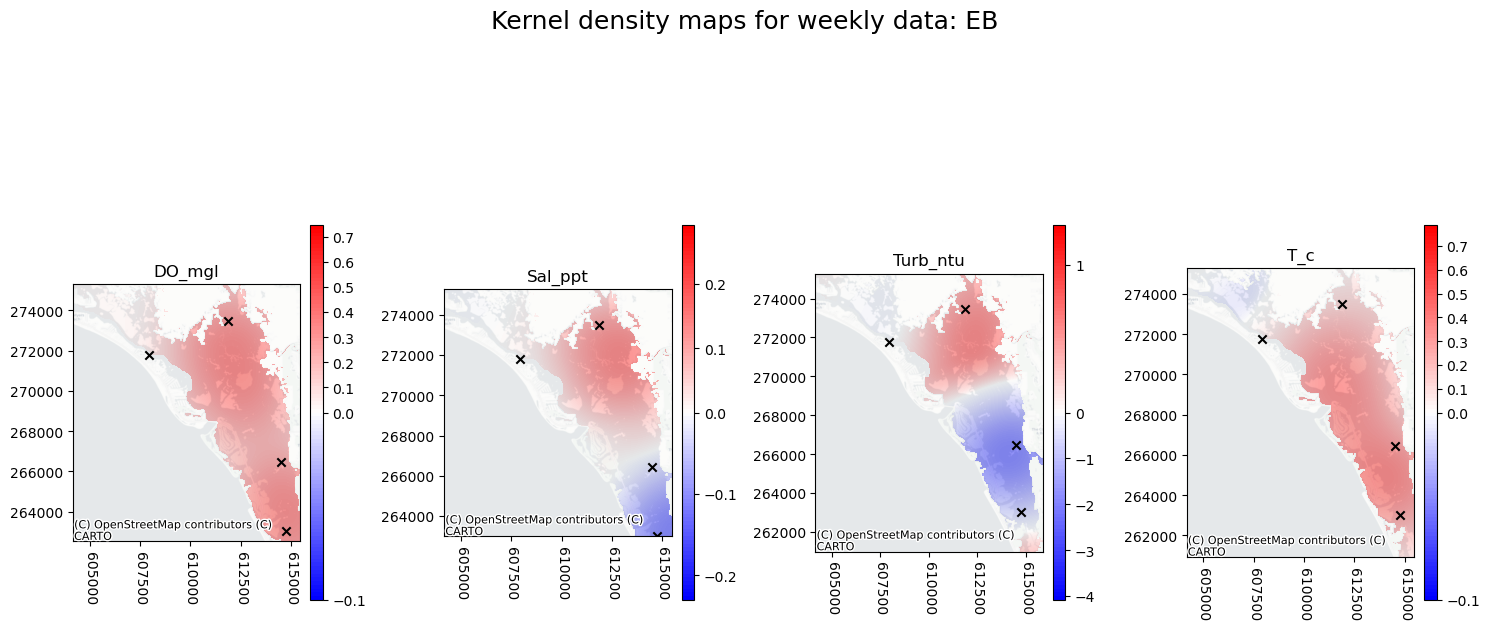

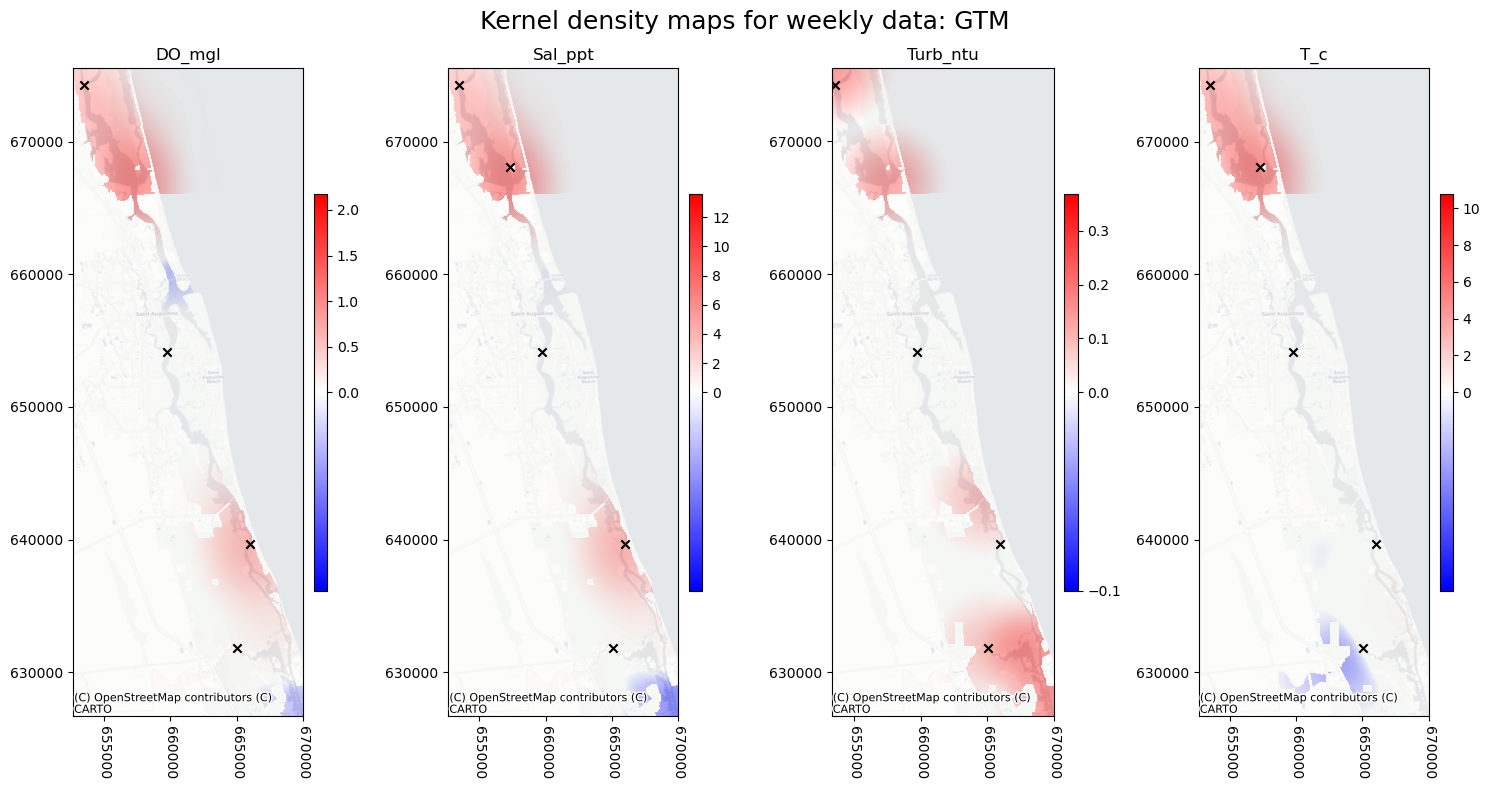

In [20]:
for wb in wb_list:
    fig, axs = plt.subplots(1, 4, figsize=(15, 8))
    fig.suptitle(f'Kernel density maps for weekly data: {wb}',fontsize=18)

    for i, para in enumerate(para_list):
        # ax = axs[i // 2, i % 2]  # Determine subplot position
        ax = axs[i]  # Determine subplot position
        
        # Read in the shapefile
        barrier = gpd.read_file(gis_path + "managed_area_boundary/" + str(wb) + ".shp",crs="EPSG:3086")
        barrier.plot(facecolor='none',edgecolor='none',alpha = 0,ax=ax)
        geometry = [feature["geometry"] for feature in barrier.__geo_interface__["features"]]
        name = str(wb) + "_" + str(para) + "_kd.tif"
        conshpname = str(wb) + "_" + str(para) + "_con.shp"
        point_con = gpd.read_file(gis_path + "kde_maps/con_sites/" + conshpname)
        point_con.plot(marker = "x",color='black',ax=ax,label="Continuous")        
        
        # Open the raster file
        with rasterio.open(gis_path + "kde_maps/week/" + name) as src:
            
            dst_crs = 'EPSG:3086'
            reprojected_src = reproject_raster(src, dst_crs)
            
            out_image, out_transform = mask(reprojected_src, geometry, crop=True)
            out_image = out_image[0]
            out_image = np.ma.masked_equal(out_image, reprojected_src.nodata)
            
            # Read the raster data as a numpy array
            raster_data = src.read(1)  # Read the first band
            max_v = np.max(raster_data)
            min_v = min(- 0.1,np.min(raster_data))
            
            # Normalizer with central value at 0
            norm = mcolors.TwoSlopeNorm(vmin=min_v, vcenter=0, vmax=max_v)
            
            # Plot the image
            im = ax.imshow(out_image, cmap=cm, norm = norm, extent=rasterio.plot.plotting_extent(reprojected_src))
            fig.colorbar(im, ax=ax,fraction=0.05, pad=0.04, aspect=30)
            ax.set_title(f'{para}')

            # Add basemap
            try:
                cx.add_basemap(ax,source=cx.providers.CartoDB.Positron,alpha=0.6, crs="EPSG:3086")
            except Exception as e:
                print(f"Error adding basemap: {e}")
                
            # Set vertical x-axis labels
            ax.xaxis.set_label_position('top')
            for label in ax.get_xticklabels():
                label.set_rotation(270)
    
    plt.tight_layout()
    plt.savefig(gis_path + "kde_maps/"+f'{wb}_w.jpg', dpi=300, format='jpg')
    plt.show()


### 5. Generate KDE maps for monthly data

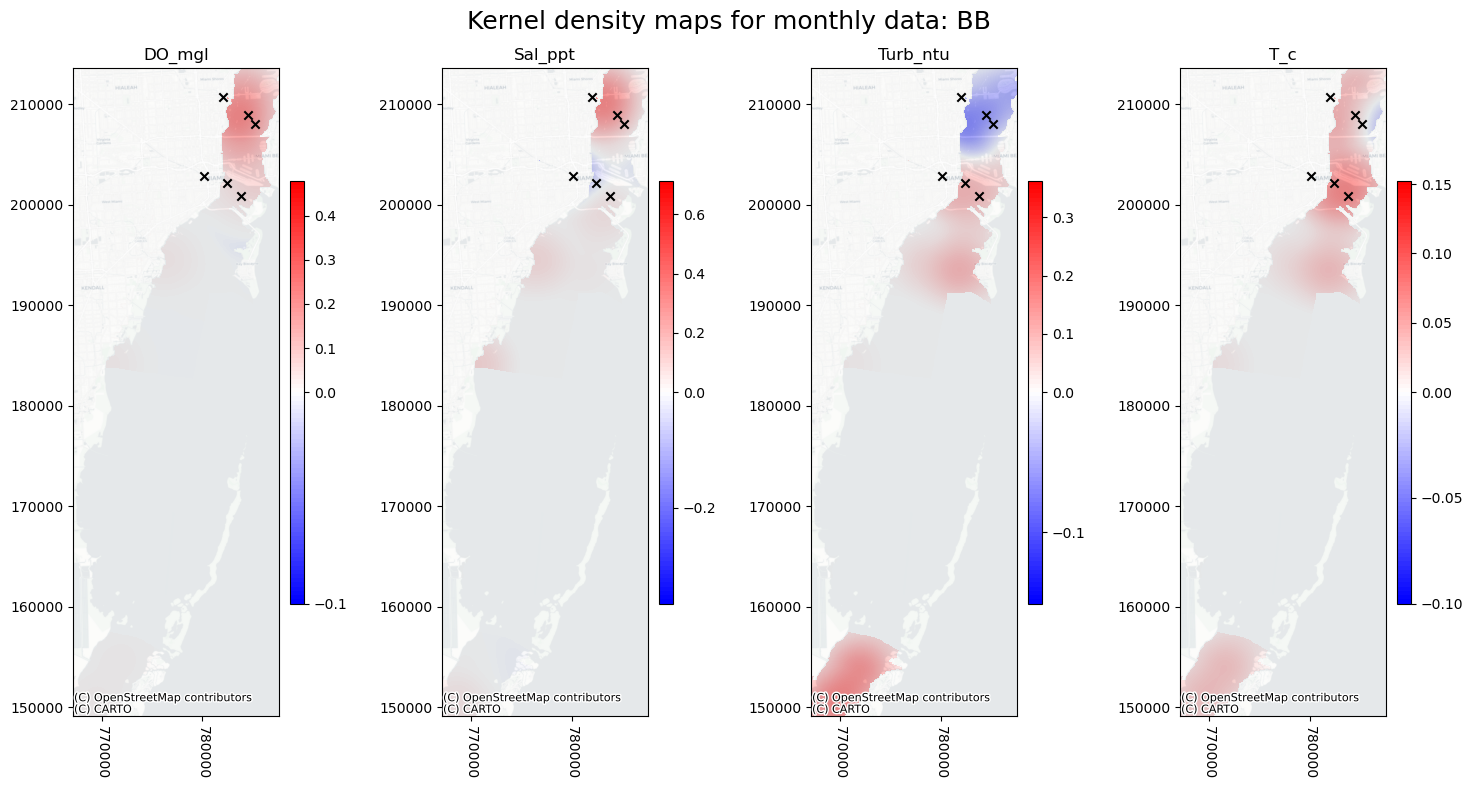

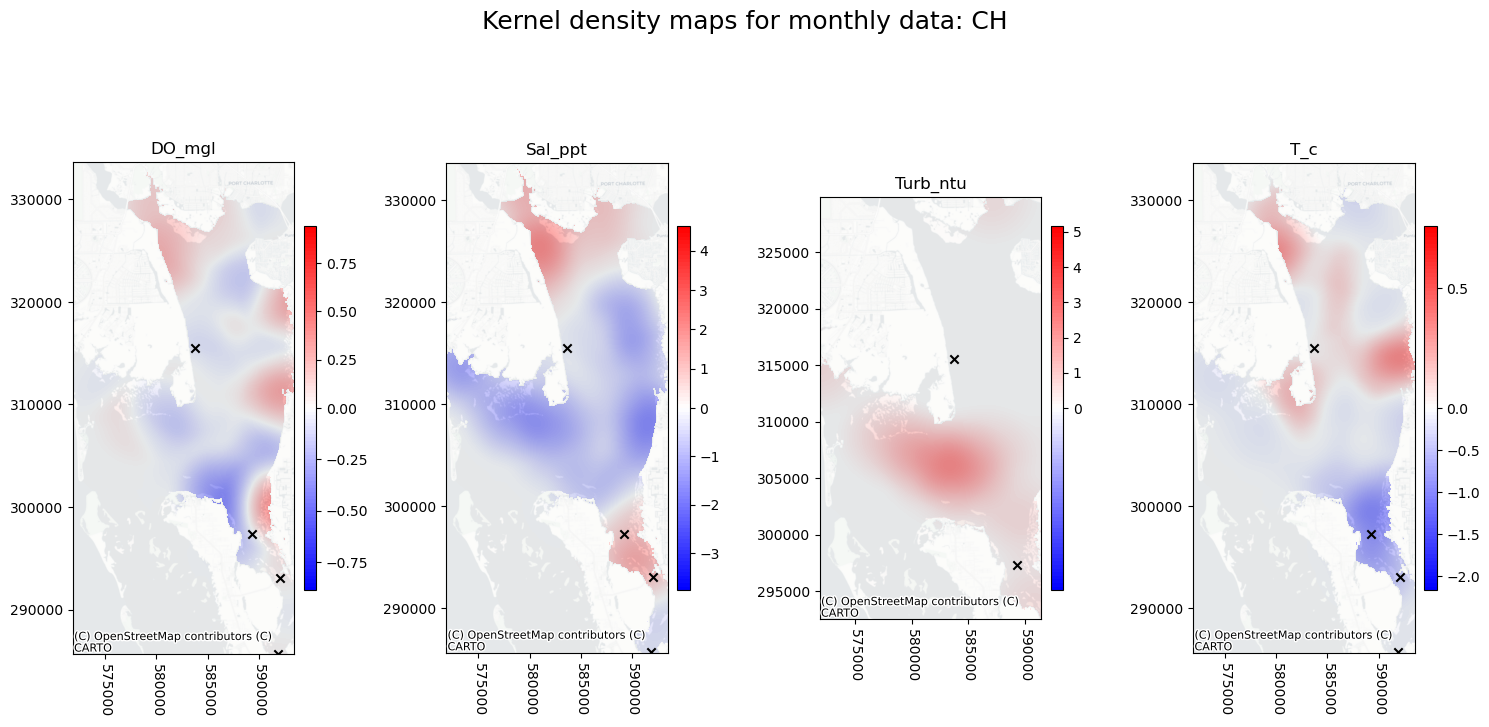

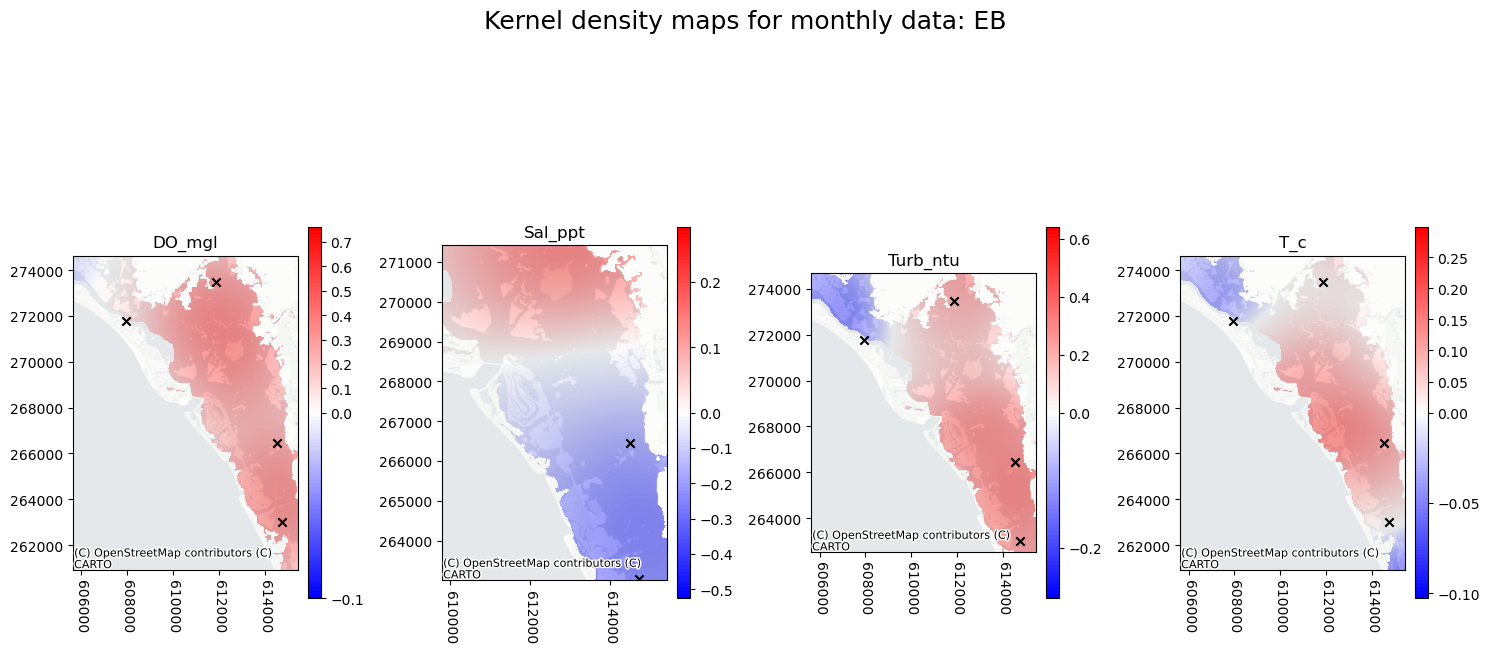

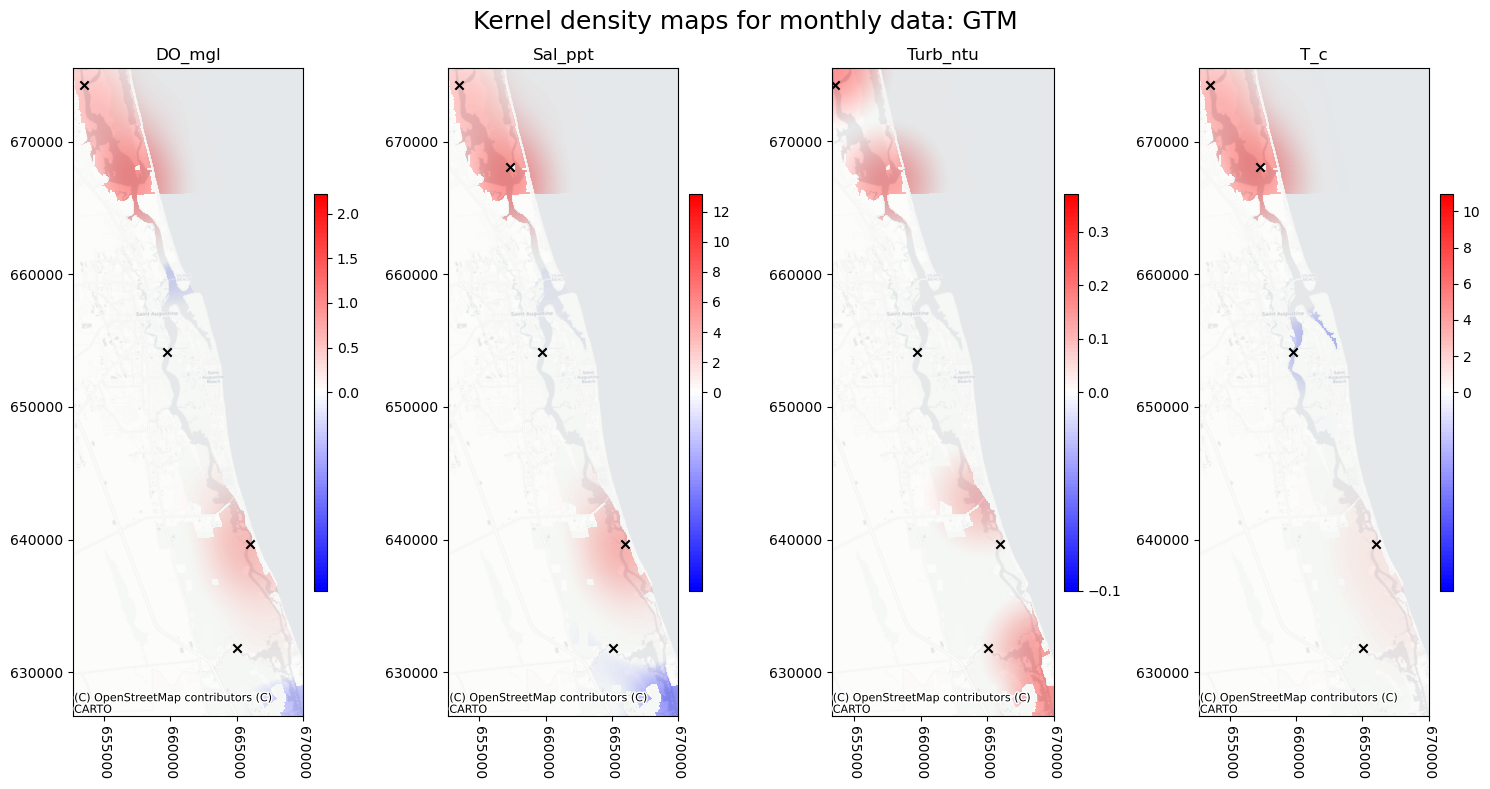

In [22]:
for wb in wb_list:
    fig, axs = plt.subplots(1, 4, figsize=(15, 8))
    fig.suptitle(f'Kernel density maps for monthly data: {wb}', fontsize=18)

    for i, para in enumerate(para_list):
        # ax = axs[i // 2, i % 2]  # Determine subplot position
        ax = axs[i]  # Determine subplot position

        # Read in the shapefile
        barrier = gpd.read_file(gis_path + "managed_area_boundary/" + str(wb) + ".shp",crs="EPSG:3086")
        barrier.plot(facecolor='none',edgecolor='none',alpha = 0,ax=ax)
        geometry = [feature["geometry"] for feature in barrier.__geo_interface__["features"]]
        name = str(wb) + "_" + str(para) + "_kd.tif"
        conshpname = str(wb) + "_" + str(para) + "_con.shp"
        point_con = gpd.read_file(gis_path + "kde_maps/con_sites/" + conshpname)
        point_con.plot(marker = "x",color='black',ax=ax,label="Continuous")
        
        # Open the raster file
        with rasterio.open(gis_path + "kde_maps/month/" + name) as src:
            dst_crs = 'EPSG:3086'
            reprojected_src = reproject_raster(src, dst_crs)
            
            out_image, out_transform = mask(reprojected_src, geometry, crop=True)
            out_image = out_image[0]
            out_image = np.ma.masked_equal(out_image, reprojected_src.nodata)
            
            # Read the raster data as a numpy array
            raster_data = src.read(1)  # Read the first band
            max_v = np.max(raster_data)
            min_v = min(- 0.1,np.min(raster_data))
            
            # Normalizer with central value at 0
            norm = mcolors.TwoSlopeNorm(vmin=min_v, vcenter=0, vmax=max_v)
            
            # Plot the image
            im = ax.imshow(out_image, cmap=cm, norm = norm, extent=rasterio.plot.plotting_extent(reprojected_src))
            fig.colorbar(im, ax=ax,fraction=0.05, pad=0.04, aspect=30)
            ax.set_title(f'{para}')

            # Add basemap
            try:
                cx.add_basemap(ax,source=cx.providers.CartoDB.Positron,alpha=0.6, crs="EPSG:3086")
            except Exception as e:
                print(f"Error adding basemap: {e}")
            
            # Set vertical x-axis labels
            ax.xaxis.set_label_position('top')
            for label in ax.get_xticklabels():
                label.set_rotation(270)
                
    plt.tight_layout()
    plt.savefig(gis_path + "kde_maps/"+f'{wb}_m.jpg', dpi=300, format='jpg')

    plt.show()